# Train Model

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

import mydatalabeling as mdl
import myplotlib as mpl
import mytalib as mtal

%matplotlib inline
import matplotlib.pyplot as plt
import plotly.offline as py
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pandas as pd
import numpy as np
import multiprocessing as mp

In [2]:
df_all = pd.read_pickle('final_ds_labeled_small.pkl')
display(df_all.columns)
df_all.head()

Index(['Nr', 'date', 'open', 'high', 'low', 'close', 'sum_vol', 'time',
       'fastma', 'slowema', 'RSI_close_30', 'dir', 'touch_tp', 'cross_idx',
       'raw_return'],
      dtype='object')

,Nr,date,open,high,low,close,sum_vol,time,fastma,slowema,RSI_close_30,dir,touch_tp,cross_idx,raw_return
0,0,2017-01-03,0.0000,0.0000,-0.0100,0.0000,1232,09:30:08,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN
1,5,2017-01-03,-0.0195,0.0400,-0.0195,0.0000,1062,09:30:15,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN
2,11,2017-01-03,-0.0200,-0.0200,-0.1299,-0.1299,1196,09:31:04,-0.1299,-0.1299,-0.1299,0.0,0.0,0.0,NaN
3,16,2017-01-03,-0.1102,-0.1092,-0.1102,-0.1092,1066,09:32:07,-0.1092,-0.1092,-0.1092,0.0,0.0,0.0,NaN
4,18,2017-01-03,-0.1200,-0.0950,-0.1200,-0.0991,1319,09:32:08,-0.0991,-0.0991,-0.0991,0.0,0.0,0.0,NaN


# Prepare dataset

In [3]:
%%time
rdf = df_all


CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 15 µs


In [4]:
#only events
f = rdf.touch_tp != 0.0
rdf = rdf[f]
rdf.touch_tp.value_counts()

-1.0    1616
 1.0    1406
Name: touch_tp, dtype: int64

In [5]:
#replace labels -1 -> 0
rdf.loc[:,'touch_tp']= rdf.loc[:,'touch_tp'].replace([-1.0], 0.0)

rdf.head(2)

,Nr,date,open,high,low,close,sum_vol,time,fastma,slowema,RSI_close_30,dir,touch_tp,cross_idx,raw_return
14,80,2017-01-03,-0.02,-0.01,-0.02,-0.02,1000,09:37:00,-0.017,-0.02,-0.02,1.0,0.0,115.0,-0.09
15,86,2017-01-03,-0.02,0.01,-0.02,0.01,1000,09:37:18,-0.003,0.01,0.01,-1.0,1.0,101.0,0.06


# Create dataset for RNN Model

In [6]:
print(rdf.date.min(), rdf.date.max())

2017-01-03 00:00:00 2017-12-29 00:00:00


In [7]:
#select columns 
y_col = 'touch_tp'
x_cols = ['Nr', 'open', 'high', 'low', 'close', 'sum_vol', 'fastma', 'slowema', 'RSI_close_30', 'dir']
#x_cols = ['close', 'Nr']

#split to train test dataset
#train dataset from 2009 to 2017
f_train = rdf.date < "2017-07-01"
x_train_df = rdf.loc[f_train, x_cols]
y_train_df = rdf.loc[f_train, y_col]

#validation from 2018 to 2019
f_val = (rdf.date > "2017-09-01") 

x_val_df = rdf.loc[f_val,x_cols]
y_val_df = rdf.loc[f_val,y_col]

#test from 2017 to 2018
f_test = (rdf.date > "2017-07-01") & (rdf.date < "2017-09-01")

x_test_df = rdf.loc[f_test,x_cols]
y_test_df = rdf.loc[f_test,y_col]


#calculate weight
wc = y_train_df.value_counts()

weight_for_0 = (1 / wc[0])*(wc[0]+wc[1])/2.0
weight_for_1 = (1 / wc[1])*(wc[0]+wc[1])/2.0

print('weight_for_0 {:.2f}'.format(weight_for_0))
print('weight_for_1 {:.2f}'.format(weight_for_1))

class_weight = {0: weight_for_0, 1: weight_for_1}

weight_for_0 0.95
weight_for_1 1.05


In [8]:
print('x_train_df.shape:',x_train_df.shape)
print('y_train_df.shape:',y_train_df.shape)
print('x_val_df.shape  :',x_val_df.shape  )
print('y_val_df.shape  :',y_val_df.shape  )
print('x_test_df.shape :',x_test_df.shape )
print('y_test_df.shape :',y_test_df.shape )

x_train_df.shape: (1768, 10)
y_train_df.shape: (1768,)
x_val_df.shape  : (824, 10)
y_val_df.shape  : (824,)
x_test_df.shape : (426, 10)
y_test_df.shape : (426,)


#### Next code is a magic.. because I'm to stupid for tensorflow %)
#### The way that I found to convert my data is very strange

In [9]:
def _to_tensor(arg): 
  arg = tf.convert_to_tensor(arg, dtype=tf.float32) 
  return arg 

def my_scale_0_to_1(x):
    current_min = tf.reduce_min(x)
    current_max = tf.reduce_max(x)
    return tf.divide(tf.subtract(x, current_min), tf.subtract(current_max, current_min))


In [10]:
dx_train = {}
dx_eval = {}
dx_test = {}

#x_rnn_cols = ['open', 'high', 'low', 'close', 'sum_vol', 'fastma', 'slowema', 'RSI_close_30']
#x_rnn_cols = [ 'close']
x_rnn_cols = []
#x_cols = ['Nr']
x_cols = ['open', 'high', 'low', 'close', 'sum_vol', 'fastma', 'slowema', 'RSI_close_30']


for c in x_rnn_cols:
    print(c)
    dx_train[c] = my_scale_0_to_1(tf.squeeze(_to_tensor(list(x_train_df.loc[:,[c]].values)),1))
    dx_eval[c] = my_scale_0_to_1(tf.squeeze(_to_tensor(list(x_val_df.loc[:,[c]].values)),1))
    dx_test[c] = my_scale_0_to_1(tf.squeeze(_to_tensor(list(x_test_df.loc[:,[c]].values)),1))

for c in x_cols:
    print(c)
    dx_train[c] = my_scale_0_to_1(my_scale_0_to_1(_to_tensor(list(x_train_df[c].values))))
    dx_eval[c] = my_scale_0_to_1(my_scale_0_to_1(_to_tensor(list(x_val_df[c].values))))
    dx_test[c] = my_scale_0_to_1(my_scale_0_to_1(_to_tensor(list(x_test_df[c].values))))

ty_train = _to_tensor(y_train_df.values)
ty_eval = _to_tensor(y_val_df.values)
ty_test = _to_tensor(y_test_df.values)

open
high
low
close
sum_vol
fastma
slowema
RSI_close_30


In [11]:
BATCH_SIZE = 1000
BUFFER_SIZE = 10000

train_tf = tf.data.Dataset.from_tensor_slices((dx_train, ty_train))
train_tf = train_tf.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_tf = tf.data.Dataset.from_tensor_slices((dx_eval,ty_eval))
val_tf = val_tf.batch(BATCH_SIZE).repeat()

#test_tf = tf.data.Dataset.from_tensor_slices((dx_test, ty_test))
#test_tf = test_tf.batch(len(list(test_tf)))
test_tf = tf.data.Dataset.from_tensor_slices(dx_test)

In [12]:
dx_shapes = {}
for feature_batch, y in train_tf.take(1):
  for key, value in feature_batch.items():
    #print("{}: {} -> {}".format(key, value.shape[-2:],y.shape))
    dx_shapes[key] = value.shape[-2:]
print(dx_shapes)

{'open': TensorShape([1000]), 'high': TensorShape([1000]), 'low': TensorShape([1000]), 'close': TensorShape([1000]), 'sum_vol': TensorShape([1000]), 'fastma': TensorShape([1000]), 'slowema': TensorShape([1000]), 'RSI_close_30': TensorShape([1000])}


# Create RNN Model

In [13]:
#inputs 
#feature_columns = []
feature_layer_inputs_rnn = {}
feature_layer_inputs = {}


for key in x_rnn_cols:#dx_shapes.keys():
    #feature_columns.append(tf.feature_column.numeric_column(key))
    feature_layer_inputs_rnn[key] = tf.keras.Input(shape=dx_shapes[key], name=key)
    print(feature_layer_inputs_rnn[key])
    
for key in x_cols:#dx_shapes.keys():
    #feature_columns.append(tf.feature_column.numeric_column(key))
    feature_layer_inputs[key] = tf.keras.Input(shape=(1,), name=key)
    print(feature_layer_inputs[key])
    
list_of_lstm_inputs = [v for v in feature_layer_inputs_rnn.values()]
list_of_Num_inputs = [v for v in feature_layer_inputs.values()]
all_inputs = list_of_lstm_inputs + list_of_Num_inputs

opt = tf.keras.optimizers
l = tf.keras.layers

#feature_columns_input = tf.keras.layers.DenseFeatures(feature_columns)
#feature_layer_outputs = feature_columns_input(feature_layer_inputs)
#print('f',feature_columns_input)
#print(feature_layer_outputs)
print('---input rnn', list_of_lstm_inputs)
print('---input', list_of_Num_inputs)

#all_tstm_inputs = tf.concat(values=list_of_lstm_inputs, axis=-1, name='all_tstm_inputs')
#print(all_tstm_inputs.shape)
all_num_inputs = tf.concat(values=list_of_Num_inputs, axis=-1, name='all_num_inputs')
print(all_num_inputs.shape)

#d1 = l.LSTM(5, activation='relu')(all_tstm_inputs)
d2 = l.Dense(10, activation='relu')(all_num_inputs)
#d2 = l.Dense(5, activation='relu')(d2)
#d1_d2_conc = tf.concat(values=[d1,d2], axis=-1, name = 'd1_d2_conc')
#output = l.Dense(2, activation='softmax')(d1_d2_conc)
output = l.Dense(1, activation='sigmoid')(d2)


model = tf.keras.Model(inputs=all_inputs, outputs=output)


METRICS = [
      #tf.keras.metrics.TruePositives(name='tp'),
      #tf.keras.metrics.FalsePositives(name='fp'),
      #tf.keras.metrics.TrueNegatives(name='tn'),
      #tf.keras.metrics.FalseNegatives(name='fn'), 
      #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      #tf.keras.metrics.Precision(name='precision'),
      #tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
      tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]
# + [tf.keras.metrics.Recall(class_id=i) for i in range(2)]



model.compile(
    #loss='sparse_categorical_crossentropy',
    loss='binary_crossentropy',
    optimizer=opt.Adam(lr=0.001),
    metrics=METRICS)

Tensor("open:0", shape=(None, 1), dtype=float32)
Tensor("high:0", shape=(None, 1), dtype=float32)
Tensor("low:0", shape=(None, 1), dtype=float32)
Tensor("close:0", shape=(None, 1), dtype=float32)
Tensor("sum_vol:0", shape=(None, 1), dtype=float32)
Tensor("fastma:0", shape=(None, 1), dtype=float32)
Tensor("slowema:0", shape=(None, 1), dtype=float32)
Tensor("RSI_close_30:0", shape=(None, 1), dtype=float32)
---input rnn []
---input [<tf.Tensor 'open:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'high:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'low:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'close:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'sum_vol:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'fastma:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'slowema:0' shape=(None, 1) dtype=float32>, <tf.Tensor 'RSI_close_30:0' shape=(None, 1) dtype=float32>]
(None, 8)


In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
open (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
high (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
low (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
close (InputLayer)              [(None, 1)]          0                                            
______________________________________________________________________________________________

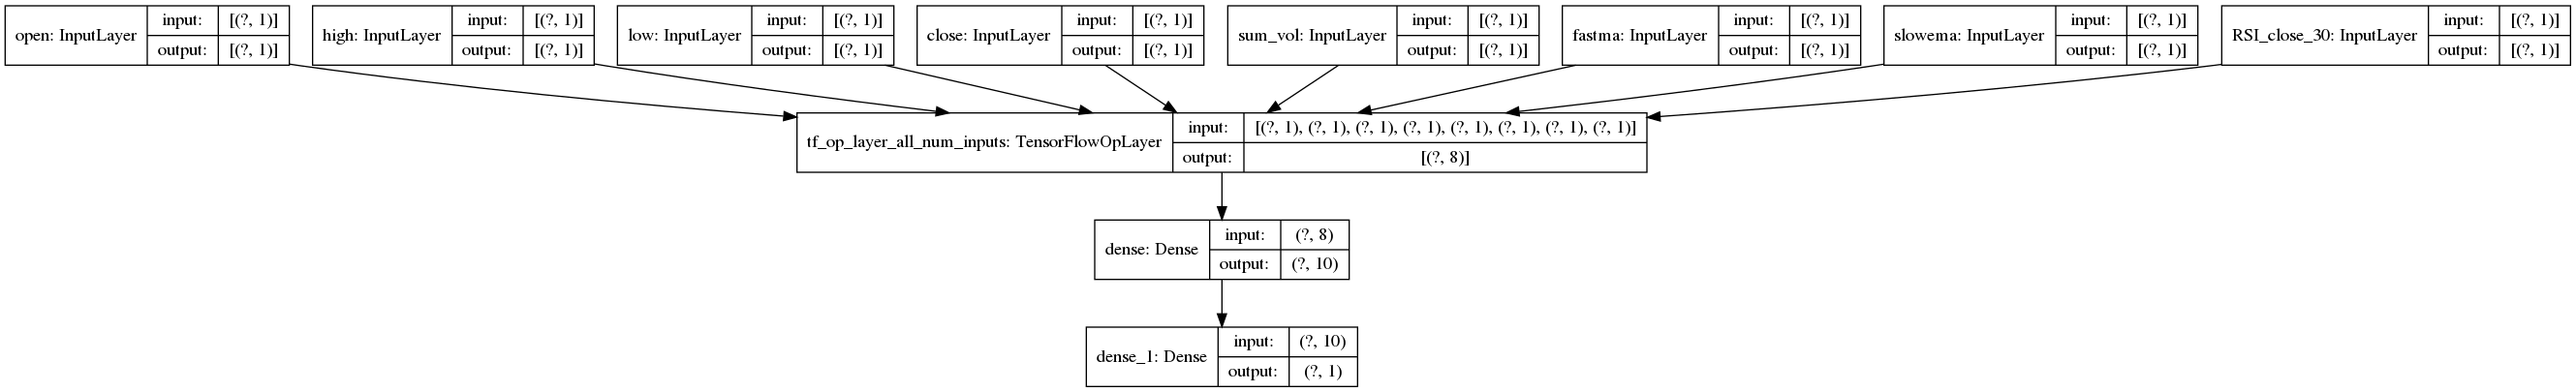

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True,show_layer_names=True,)

In [16]:
#check if is working
for x, y in val_tf.take(1):
    #print(x,y)
    print(model.predict(x).shape)
    y_prob = model.predict(x)
    y_classes = y_prob.argmax(axis=-1)
    print(y_classes)

(824, 1)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0

### Train the model

In [17]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

history = model.fit(train_tf, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_tf, 
                      validation_steps=50,
                      class_weight=class_weight)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 3s 13ms/step - loss: 0.6893 - auc: 0.5663 - accuracy: 0.5255 - val_loss: 0.6854 - val_auc: 0.5793 - val_accuracy: 0.5570
Epoch 2/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6875 - auc: 0.5725 - accuracy: 0.5255 - val_loss: 0.6850 - val_auc: 0.5755 - val_accuracy: 0.5570
Epoch 3/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6862 - auc: 0.5727 - accuracy: 0.5255 - val_loss: 0.6850 - val_auc: 0.5749 - val_accuracy: 0.5570
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.6854 - auc: 0.5735 - accuracy: 0.5255 - val_loss: 0.6854 - val_auc: 0.5757 - val_accuracy: 0.5570
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6850 - auc: 0.5737 - accuracy: 0.5255 - val_loss: 0.6863 - val_auc: 0.5752 - val_accuracy: 0.5570
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.6848 - auc

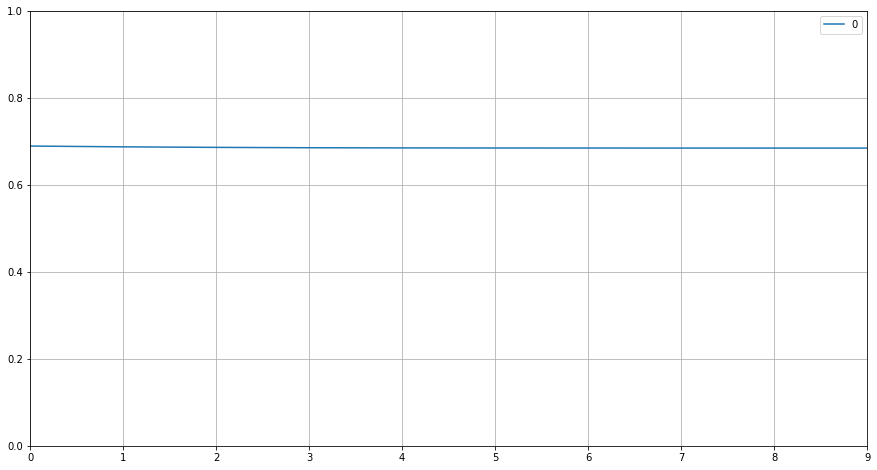

In [18]:
#plot the history
pd.DataFrame.from_dict(history.history['loss']).plot(figsize=(15, 8))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

### Predict test data

In [19]:
y_prob = model.predict(x=test_tf.batch(batch_size=1000), steps=1, verbose=True)

1/1 [==============================] - 0s 40ms/step


In [20]:
# plotroc curve

In [21]:
from  sklearn.metrics import roc_curve, auc
def plotRoc(y, y_proba):

    fpr, tpr, _ = roc_curve(y, y_proba)
    roc_auc = auc(fpr, tpr)

    lw = 2
    trace1 = go.Scatter(x=fpr, y=tpr, 
                        mode='lines', 
                        line=dict(color='darkorange', width=lw),
                        name='ROC curve (area = %0.2f)' % roc_auc
                    )

    trace2 = go.Scatter(x=[0, 1], y=[0, 1], 
                        mode='lines', 
                        line=dict(color='navy', width=lw, dash='dash'),
                        showlegend=False)

    layout = go.Layout(title='Receiver operating characteristic example',
                    xaxis=dict(title='False Positive Rate'),
                    yaxis=dict(title='True Positive Rate'))

    fig = go.Figure(data=[trace1, trace2], layout=layout)
    fig.show()

In [22]:
plotRoc(ty_test.numpy(), y_prob.flatten())

In [23]:
x_test_df['pred'] = y_prob
x_test_df['y'] = ty_test.numpy()
f = x_test_df.dir != x_test_df.y
x_test_df[f][['dir', 'pred', 'y']]
f2 = x_test_df[f][['dir', 'pred', 'y']].y == 1
x_test_df[f][['dir', 'pred', 'y']][f2]

,dir,pred,y
50859,-1.0,0.256540,1.0
50913,-1.0,0.307045,1.0
51074,-1.0,0.565543,1.0
51143,-1.0,0.563747,1.0
51211,-1.0,0.559659,1.0
...,...,...,...
61448,-1.0,0.412263,1.0
61453,-1.0,0.414365,1.0
61534,-1.0,0.409484,1.0
61566,-1.0,0.423687,1.0


In [24]:
f = x_test_df['pred'] > 0.5
x_test_df[f][['dir', 'pred', 'y']].y.value_counts()

1.0    50
0.0    42
Name: y, dtype: int64